# Modeling

**Imports**

In [113]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# imports for modeling
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

# system import to access file on different directory 
import sys
sys.path.append("/Users/migashane/CodeUp/Data_Science/telco_churn_classification_project/util_")
import prepare_
import knn_model_


**Get data**

In [2]:
# get the fully cleaned data with dummies
telco = prepare_.final_prep_telco()

# split data into train, validate and test
train, validate, test = prepare_.split_data_(df=telco,
                     test_size=0.2, 
                     validate_size=0.2,
                    stratify_col="churn",
                    random_state=95)

# look at the different splits
train.shape, validate.shape, test.shape

((4225, 47), (1409, 47), (1409, 47))

In [89]:
train.head().T

,2872,1106,2081,6880,6205
senior_citizen,0.00,0.00,1.00,1.00,0.0
tenure,48.00,2.00,70.00,27.00,52.0
monthly_charges,78.75,75.90,90.85,84.80,64.3
total_charges,3682.45,143.35,6470.10,2309.55,3410.6
churn,0.00,1.00,0.00,0.00,0.0
gender_female,0.00,1.00,1.00,0.00,1.0
gender_male,1.00,0.00,0.00,1.00,0.0
partner_no,1.00,1.00,0.00,0.00,0.0
partner_yes,0.00,0.00,1.00,1.00,1.0
dependents_no,0.00,1.00,1.00,1.00,1.0


### KNN


Create a KNN model to predict churn based on internet type, monthly charges, tenure,contract type, parter and depenents.

**Separate features and target**

In [122]:
features = ["internet_service_type_none", "internet_service_type_fiber optic", 
            "internet_service_type_dsl", "monthly_charges", "tenure", "contract_type_one year",
           "contract_type_two year", "contract_type_month_to_month", "dependents_yes", "partner_yes"]

# the internet type feature dummy columns for modeling for training
xtrain = train[features]
ytrain = train.churn

# the internet type feature dummy columns for modeling for validation
xvalidate = validate[features]
yvalidate = validate.churn

# the internet type feature dummy columns for modeling for testing
xTeste = test[features]
yTest = test.churn

xtrain.head(3)

,internet_service_type_none,internet_service_type_fiber optic,internet_service_type_dsl,monthly_charges,tenure,contract_type_one year,contract_type_two year,contract_type_month_to_month,dependents_yes,partner_yes
2872,0,0,1,78.75,48,1,0,0,1,0
1106,0,1,0,75.90,2,0,0,1,0,0
2081,0,1,0,90.85,70,0,0,1,0,1


**Train KNN model on different k values**

In [135]:
# the maximun number of neighbors the model should look at
# in my case it can only look at 1% of the data
k_neighbors = math.ceil(len(train) * 0.01)

# the final result metric
metrics = []

for k in range(1, k_neighbors + 1):
    train_baseline_acc_score = accuracy_score(train.churn, train.baseline)
    
    # create a knn object
    #                          n_neighborsint(default=5) 
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', p=2)
    #                                                        p=1 uses the manhattan distance

    # fit training data to the object
    knn = knn.fit(xtrain, ytrain)
    
    # make prediction of churn based on internet type
    ypred = knn.predict(xtrain)
    
    # Estimate probability for each prediction
    ypred_proba = knn.predict_proba(xtrain) # each list represents how the prediction was made

    # retrieve probability of churn
    churn_proba = []
    for i in ypred_proba:
        churn_proba.append(i[1])
    
    #USE the thing
    train_score= knn.score(xtrain, ytrain)
    validate_score = knn.score(xvalidate, yvalidate)
    
    # create a dictionary of scores
    output = {
        "k": k,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": train_baseline_acc_score - train_score,
        "train_baseline_diff": train_baseline_acc_score - validate_score,
        "baseline_accuracy": train_baseline_acc_score,
    }
    
    metrics.append(output)

In [136]:
model_df = pd.DataFrame(metrics)
model_df.head()

,k,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
0,1,0.991006,0.740241,0.250765,-0.005567,0.734675
1,2,0.865562,0.757275,0.108287,-0.022600,0.734675
2,3,0.861538,0.748758,0.112780,-0.014083,0.734675
3,4,0.841420,0.762952,0.078468,-0.028278,0.734675
4,5,0.833609,0.762243,0.071367,-0.027568,0.734675


**Visualize my models**

<Figure size 500x300 with 0 Axes>

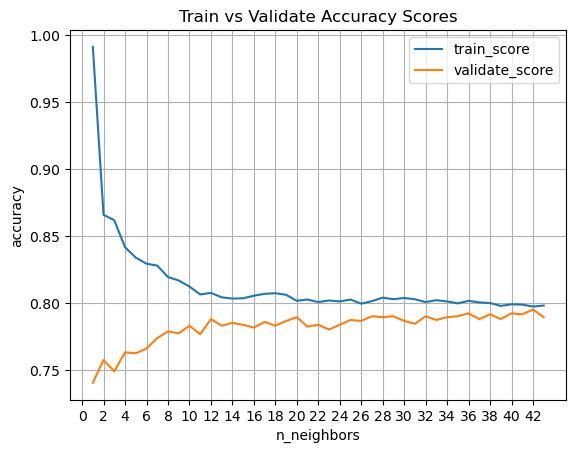

In [152]:

#PLOT train vs validate
plt.figure(figsize=(5,3))
model_df[model_df.columns[:-3]].set_index("k").plot()
plt.xticks(np.arange(0,44, 2))
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')
plt.title("Train vs Validate Accuracy Scores")
plt.grid()
plt.show()

**Best KNN model**

In [160]:
# find the model with smallest ifference between the train and validate
# this will become the best model for knn

model_df[model_df.difference == abs(model_df.difference).min()]

,k,train_score,validate_score,difference,train_baseline_diff,baseline_accuracy
41,42,0.79716,0.79489,0.00227,-0.060215,0.734675


### Decision tree

### Random forest

### Logistic regression

### What month are customers most likely to churn and does that depend on their contract type?

### KNN

### Decision tree

### Random forest

### Logistic regression